# Cell 1: Install packages and set up plotting environment

In [2]:
# Install frequently used data analysis packages
import subprocess
import sys

packages = ['pandas', 'matplotlib', 'numpy', 'scipy', 'openpyxl', 'xlrd']
for package in packages:
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
print("All packages installed successfully!")

# Load data from Excel file
import pandas as pd
df = pd.read_excel('MagneticParameters.xlsx')

# Set matplotlib plot parameters
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import numpy as np

plt.style.reload_library()
matplotlib.rcParams.update({
    'font.size': 7, 
    'font.family': 'STIXGeneral', 
    'mathtext.fontset': 'stix'
})

# Plot appearance settings
fig_width = 4       # [cm]
fig_height = 3      # [cm]
font_size = 7       # [pt]
marker_size = 5
x_tick_pad = 2
y_tick_pad = 2
x_label_pad = 0.5
y_label_pad = 1
resolution = 300

Installing pandas...
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Installing matplotlib...
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Installing numpy...
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Installing scipy...
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Installing openpyxl...
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Installing xlrd...
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


All packages installed successfully!


# Cell 2: Loss calculation and efficiency estimation

In [3]:
import math

# Basic parameters
f = 85e3                 # Frequency [Hz]
w = 2 * math.pi * f      # Angular frequency [rad/s]
Pout = 50000             # Output power [W]
Vdc = 400                # DC link voltage [V]
Vbat = 400               # Battery voltage [V]

# Extract parameters from Excel
Np = df.loc[0, 'N1[turn]']
Ns = df.loc[0, 'Nr[turn]']
L1 = df.loc[0, 'L1[H]']
Lr = df.loc[0, 'Lr[H]']
k_x0y0 = df.loc[0, 'k_x0_y0']
I1 = df.loc[0, 'I1[A(rms)]'] # Primary current [A, rms]

# Resonant design parameters
c1 = math.pi * w * L1 * I1 * math.sqrt(2) / (4 * Vdc) # Note that I1 is rms value. c1 = C1pa/C1sb + 1
c2 = (math.pi**2 * w * math.sqrt(L1 * Lr) * Pout) / (8 * k_x0y0 * c1 * Vdc * Vbat) # c2 = Crpa/C1sb + 1 

# RMS current values
I1a = (4 * c1 * c2 * Vbat * k_x0y0) / (math.pi * w * math.sqrt(L1) * math.sqrt(Lr)) / math.sqrt(2)
I1b = (4 * c1 * Vdc) / (math.pi * w * L1) / math.sqrt(2)
Ira = (4 * c1 * c2 * Vdc * k_x0y0) / (math.pi * w * math.sqrt(L1) * math.sqrt(Lr)) / math.sqrt(2)
Irb = (4 * c2 * Vbat) / (math.pi * w * Lr) / math.sqrt(2)

# Voltage across coils (rms)
VL1 = math.sqrt((4 * math.sqrt(L1) * Vbat * k_x0y0 * c2 / (math.pi * math.sqrt(Lr)))**2 + (4 * Vdc * c1 / math.pi)**2) / math.sqrt(2)
VLr = math.sqrt((4 * math.sqrt(Lr) * Vdc * k_x0y0 * c1 / (math.pi * math.sqrt(L1)))**2 + (4 * Vbat * c2 / math.pi)**2) / math.sqrt(2)

# Quality factors
QL = 400
QC = 500

# Filter components
Lf = 5.31e-6    # [H]
Cf = 0.66e-6    # [F]

# Resonant components (resonant inductors and capacitors)
L1sa = L1 / c1
C1sb = c1 / (w**2 * L1 * (c1 - 1))
C1pa = c1 / (L1 * w**2)
Crpa = c2 / (Lr * w**2)
Crsb = c2 / (Lr * w**2 * (c2 - 1))
Lrsa = Lr / c2

# Equivalent resistances
def r_L(L, Q): return w * L / Q
def r_C(C, Q): return 1 / (w * C * Q)

rLf = r_L(Lf, QL)
rCf = r_C(Cf, QC)
rL1 = r_L(L1, QL)
rL1sa = r_L(L1sa, QL)
rC1pa = r_C(C1pa, QC)
rC1sb = r_C(C1sb, QC)
rLr = r_L(Lr, QL)
rLrsa = r_L(Lrsa, QL)
rCrpa = r_C(Crpa, QC)
rCrsb = r_C(Crsb, QC)

# Loss calculations
Loss_Lf = rLf * I1a**2
Loss_Cf = rCf * I1a**2
Loss_Filter = Loss_Lf + Loss_Cf

Loss_L1 = rL1 * I1b**2
Loss_L1sa = rL1sa * I1a**2
Loss_C1pa = rC1pa * (I1a + I1b)**2
Loss_C1sb = rC1sb * I1b**2

# Reuse same losses for 4-transmitter system
Loss_L2 = Loss_L3 = Loss_L4 = Loss_L1
Loss_L2sa = Loss_L3sa = Loss_L4sa = 0
Loss_C2pa = Loss_C3pa = Loss_C4pa = rC1pa * I1b**2
Loss_C2sb = Loss_C3sb = Loss_C4sb = rC1sb * I1b**2

Loss_Lr = rLr * Irb**2
Loss_Crsb = rCrsb * Irb**2
Loss_Crpa = rCrpa * Irb**2
Loss_Lrsa = rLrsa * Ira**2

# Inverter and diode losses
Rsw = 3.7e-3 * 2       # Switch resistance (from datasheet for CAS325M12HM2)
Vforward = 1.6 * 2     # Diode forward drop (from datasheet for CAS325M12HM2)
Loss_Inverter = Rsw * I1a**2
Loss_Diode = Vforward * Ira

# Total losses and efficiency
Loss_single_total = Loss_L1 + Loss_L1sa + Loss_C1sb + Loss_C1pa + Loss_Lr + Loss_Crsb + Loss_Lrsa + Loss_Crpa + Loss_Inverter + Loss_Diode + Loss_Filter
Loss_four_total = (Loss_L1 + Loss_L2 + Loss_L3 + Loss_L4 +
                   Loss_L1sa + Loss_L2sa + Loss_L3sa + Loss_L4sa +
                   Loss_C1sb + Loss_C2sb + Loss_C3sb + Loss_C4sb +
                   Loss_C1pa + Loss_C2pa + Loss_C3pa + Loss_C4pa +
                   Loss_Lr + Loss_Crsb + Loss_Lrsa + Loss_Crpa +
                   Loss_Inverter + Loss_Diode + Loss_Filter)

Loss_coil = Loss_L1 + Loss_Lr

eff_single = (Pout/(Pout + abs(Loss_single_total)))*100 
eff_four = (Pout/(Pout + abs(Loss_four_total)))*100 
eff_coil = (Pout/(Pout + abs(Loss_coil)))*100 


# Cell 3: Plot loss breakdown (pie chart)

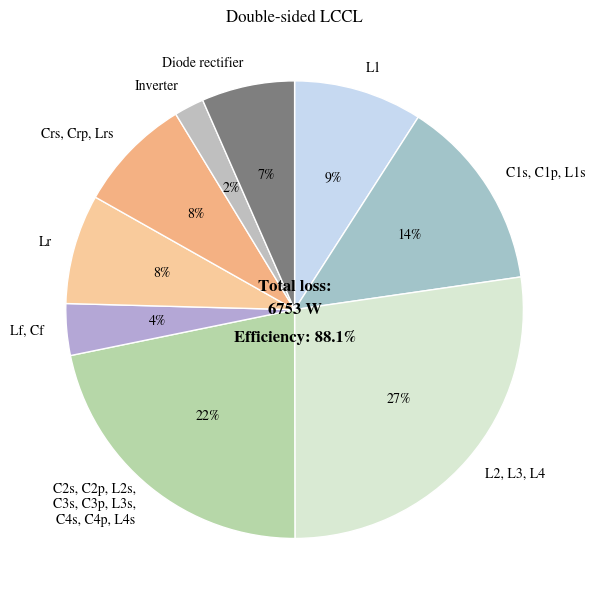

In [4]:
import matplotlib.pyplot as plt

# Losses in the order in the paper
losses_ordered = {
    "L1": Loss_L1,
    "C1s, C1p, L1s": Loss_C1sb + Loss_C1pa + Loss_L1sa,
    "L2, L3, L4": Loss_L2 + Loss_L3 + Loss_L4,
    "C2s, C2p, L2s,\nC3s, C3p, L3s,\nC4s, C4p, L4s":
        Loss_C2sb + Loss_C2pa + Loss_L2sa +
        Loss_C3sb + Loss_C3pa + Loss_L3sa +
        Loss_C4sb + Loss_C4pa + Loss_L4sa,
    "Lf, Cf": Loss_Filter,
    "Lr": Loss_Lr,
    "Crs, Crp, Lrs": Loss_Crsb + Loss_Crpa + Loss_Lrsa,
    "Inverter": Loss_Inverter,
    "Diode rectifier": Loss_Diode
}

labels = list(losses_ordered.keys())
sizes = list(losses_ordered.values())
total_loss = sum(sizes)
efficiency = eff_four  # (%)

# Color mapping (matched to the paper)
colors = [
    "#c6d9f1",  # L1 (light blue)
    "#a2c4c9",  # C1s, C1p, L1s (blue-gray)
    "#d9ead3",  # L2, L3, L4 (light green)
    "#b6d7a8",  # C2s~C4s (green)
    "#b4a7d6",  # Lf, Cf (violet)
    "#f9cb9c",  # Lr (orange)
    "#f4b183",  # Crs, Crp, Lrs (orange-brown)
    "#bfbfbf",  # Inverter (light gray)
    "#7f7f7f"   # Diode rectifier (dark gray)
]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.0f%%',
    startangle=90,
    colors=colors,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'},
    textprops={'fontsize': 10}
)

# Center annotations
ax.text(0, 0.10, "Total loss:", ha='center', va='center', fontsize=12, weight='bold')
ax.text(0, 0.00, f"{int(total_loss)} W", ha='center', va='center', fontsize=12, weight='bold')
ax.text(0, -0.12, f"Efficiency: {efficiency:.1f}%", ha='center', va='center', fontsize=12, weight='bold')

ax.axis('equal')
plt.title("Double-sided LCCL", fontsize=12)
plt.tight_layout()
plt.show()


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.3 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 536 kB 7.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# Cell 4: Export loss breakdown data to Excel for pie chart

In [5]:
import pandas as pd

# Create DataFrame from the ordered loss dictionary (used in Cell 3)
df_losses = pd.DataFrame({
    'Loss Item': list(losses_ordered.keys()),
    'Loss [W]': list(losses_ordered.values())
})

# Save to Excel
output_file = 'LossBreakdown_LCCL.xlsx'
df_losses.to_excel(output_file, index=False)

print(f"Loss breakdown data has been saved to '{output_file}'. You can now create a pie chart in Excel using this data.")


Loss breakdown data has been saved to 'LossBreakdown_LCCL.xlsx'. You can now create a pie chart in Excel using this data.
